# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__ 

1) Which living conditions affect which life outcomes (education, health or happiness) the most?

2) What is the effect of precarious housing on health (both physical and mental) and school involvement for children?

3) Following-up on school involvement: which age group (children[6,11] or adolescents[12,17]) is most impacted ?


## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [2]:
# Make custom palettes for seaborn
colors = ['#BDDBD3','#B8B8FF'] #opal & lilac
#colors_light = ['#CAE2DC','#C2C2FF'] #opal & lilac
colors_light = ['#8FA3F8','#B6F3C9'] #light blue & light green
#colors_light = ['#CAF6D8','#B2BFFA'] #mint & lavender
#colors_dark=['#62A87C','#FDE74C']  #green & yellow
colors_dark = ['#9999FF','#B0D4CB'] #lilac & opal
customLight = sns.color_palette(colors_light)
customDark = sns.color_palette(colors_dark)
customPalette = sns.color_palette(colors)

In [3]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [4]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','SEX','UAGE','STATE','UREGION','HHID']
household_id_hh = ['HHID']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS','CSPECED']
family = ['UFAMSTR','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS','NCPROBC','UMH2']
health = ['BDISBL','BHLTHN']
activities = ['UACT']
sec = ['UHINS4'] 

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0 or x >5) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + sec]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh]

In [5]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing/unusable values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the NLESSONS/CSPECED/BDISBL variable binary with Yes=1 and No=0
child['NLESSONS'].replace(2,0,inplace=True)
child['CSPECED'].replace(2,0,inplace=True)
child['BDISBL'].replace(2,0,inplace=True)
# Make the QSC5 variable (hh income vs 2x poverty line) binary with Below=0 and Above=1
child['QSC5'].replace({'1':0,'2':1,'':-1}, inplace=True)

# Normalize values for UENG(4-16), BHLTHN(1-5), UBPIA(6-18), UBPIB(6-18), UMH2(25-100), UACT(0-3), UAGG(4-16) & NCPROBC(1-3) (min-max)
child.loc[:,'UENGn'] = child['UENG'].apply(lambda x: (x-4)/(16-4) if x != -1 else x)
child.loc[:,'BHLTHNn'] = child['BHLTHN'].apply(lambda x: (x-1)/(5-1) if x != -1 else x)
child.loc[:,'UBPIAn'] = child['UBPIA'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UBPIBn'] = child['UBPIB'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UMH2n'] = child['UMH2'].apply(lambda x: (x-25)/(100-25) if x != -1 else x)
child.loc[:,'UACTn'] = child['UACT'].apply(lambda x: (x)/(3-0) if x != -1 else x)
child.loc[:,'UAGG'] = child['UAGG'].apply(lambda x: (16-x) if x != -1 else x)
child.loc[:,'UAGGn'] = child['UAGG'].apply(lambda x: x/(16-4) if x != -1 else x)
child.loc[:,'NCPROBC'] = child['NCPROBC'].apply(lambda x: 3-x if x != -1 else x)
child.loc[:,'NCPROBCn'] = child['NCPROBC'].apply(lambda x: x/2 if x != -1 else x)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,SEX,UAGE,STATE,UREGION,HHID,UENG,UENGNEG,UENGPOS,...,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,UAGGn,NCPROBCn
0,5561612801,1,1,3,WI,2,55616128,-1,-1,-1,...,1,0.75,-1.000000,0.00,-1.0,-1.000000,0.933333,-1.000000,0.000000,-1.0
1,5470400001,2,0,14,WI,2,54704000,8,1,0,...,2,1.50,0.333333,0.00,-1.0,0.416667,0.666667,0.333333,0.000000,0.5
2,5787427204,2,1,9,WI,2,57874272,12,0,0,...,2,2.00,0.666667,0.50,1.0,-1.000000,1.000000,0.666667,0.083333,0.0
3,5410681601,1,0,4,WI,2,54106816,-1,-1,-1,...,2,2.50,-1.000000,0.25,-1.0,-1.000000,0.666667,-1.000000,0.000000,-1.0
4,5051721601,2,1,17,WI,2,50517216,13,0,0,...,2,1.25,0.750000,0.25,-1.0,0.833333,0.253333,0.333333,0.416667,0.5


In [6]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal children, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal children, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal children, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal children, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [7]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 44)
fc2: (10925, 44)
fc3:(11087, 44)
fc23: (22012, 44)
True


## Linear regression models

In [8]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [9]:
# returns a regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## School involvement `UENG`

In [10]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     1444.
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.52e-58
Time:                        22:52:27   Log-Likelihood:                -48931.
No. Observations:               21087   AIC:                         9.789e+04
Df Residuals:                   21075   BIC:                         9.798e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.6909      0.177     71.762   

We can notice a few variables that have a strong impact on scholar involvement (those that have a small p-value and thus a large z-value):
- `SEX`: positive z indicates that being a female (F=1>0=M) is strongly positively associated with involvement.
- `UAGG`: negative z-value, meaning that higher parental aggravation is associated with worse school involvement.
- `UAGE`: Older children are negatively associated with involvement.
- `UACT`: Children that have a lot of extracurricular activities tend to perform better at school.
- `CSPECED`: As would be expected, children with special educationnal needs are less involved with school.

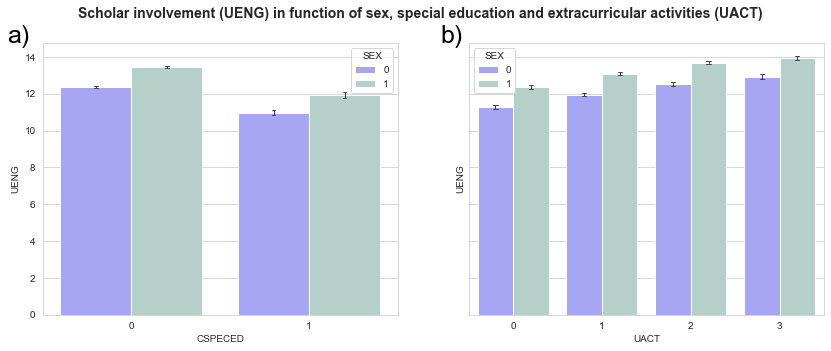

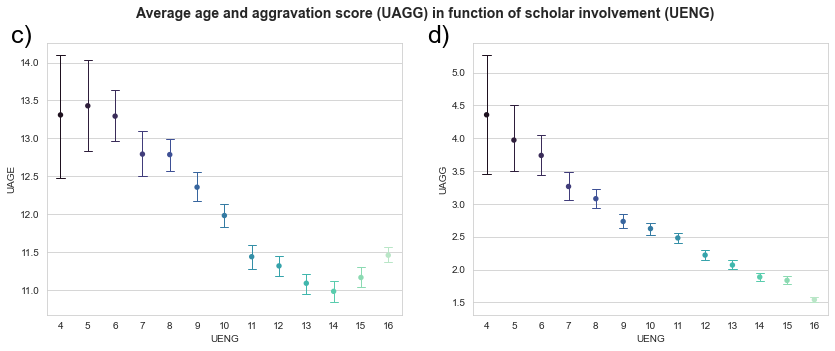

In [11]:
df = df_NN(fc23,outcome,predictors)
sns.set_style('whitegrid')
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.barplot(ax=axes[0], y='UENG', x='CSPECED', hue='SEX', palette=customDark, data=df, capsize=0.02,errwidth=1)
sns.barplot(ax=axes[1], y='UENG', x='UACT', hue='SEX', palette=customDark, data=df, capsize=0.05,errwidth=1)
plt.suptitle('Scholar involvement (UENG) in function of sex, special education and extracurricular activities (UACT)', fontsize=14, fontweight='bold')
plt.show()
    
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].text(-0.1,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UENG', y='UAGE', palette='mako', data=df,capsize=0.3,errwidth=1,markers='.')
sns.pointplot(ax=axes[1], x='UENG', y='UAGG', palette='mako', data=df,capsize=0.3,errwidth=1,markers='.')
plt.suptitle('Average age and aggravation score (UAGG) in function of scholar involvement (UENG)', fontsize=14, fontweight='bold')
plt.show()

**a)** 
**b)** 
**c)**
**d)**

## **Health indicator `BHLTHN`**

In [12]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     319.3
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.12e-41
Time:                        22:52:30   Log-Likelihood:                -27112.
No. Observations:               21471   AIC:                         5.425e+04
Df Residuals:                   21460   BIC:                         5.433e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.8017      0.076     23.767   

We can notice a few variables that have a strong impact on bad health indicator `BHLTHN`:
- `UACT`: Extracurricular activities are reducing the incidence of bad health.
- `U_SOCPOV`: The richer the family, the less unhealthy the child.
- `UMH2`: The better the parental mental health, the less unhealthy the child

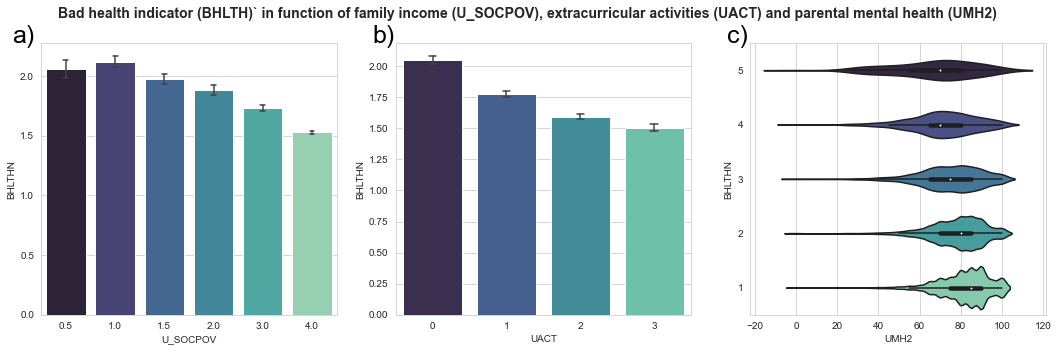

In [13]:
df = df_NN(fc23,outcome,predictors)
fig, axes = plt.subplots(1,3, figsize=(18,5))
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
axes[2].text(-0.08,1,'c)', fontsize=25, color='k', transform=axes[2].transAxes)
sns.barplot(ax=axes[0], y='BHLTHN', x='U_SOCPOV', palette='mako', data=df,capsize=0.1,errwidth=1.5)
sns.barplot(ax=axes[1], y='BHLTHN', x='UACT', palette='mako', data=df,capsize=0.1,errwidth=1.5)
sns.violinplot(ax=axes[2], x='UMH2', y='BHLTHN', palette='mako', data=df, orient='h',order=[5,4,3,2,1])
plt.suptitle('Bad health indicator (BHLTH)` in function of family income (U_SOCPOV), extracurricular activities (UACT) and parental mental health (UMH2)', fontsize=14, fontweight='bold')
plt.show()

**a)** 
**b)** 
**c)**

## **Mental health**

#### **Child mental health `NCPROBC`**

In [14]:
outcome = 'NCPROBC'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                NCPROBC   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     573.1
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           6.11e-48
Time:                        22:52:31   Log-Likelihood:                -16317.
No. Observations:               21414   AIC:                         3.266e+04
Df Residuals:                   21403   BIC:                         3.274e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2977      0.036      8.322   

We can notice a few variables that have a strong impact on child depression/sadness index `NCPROBC`:
- `UAGE`: Mental health of children gets poorer with age.
- `UFAMSTR`: The richer the family, the less unhealthy the child.
- `UAGG`: Parental aggravation is positively correlated with child depression.
- `UMH2`: The better the parental mental health, the better the child's.

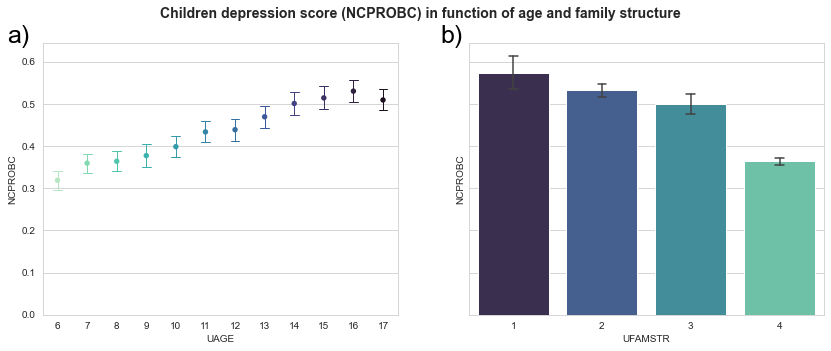

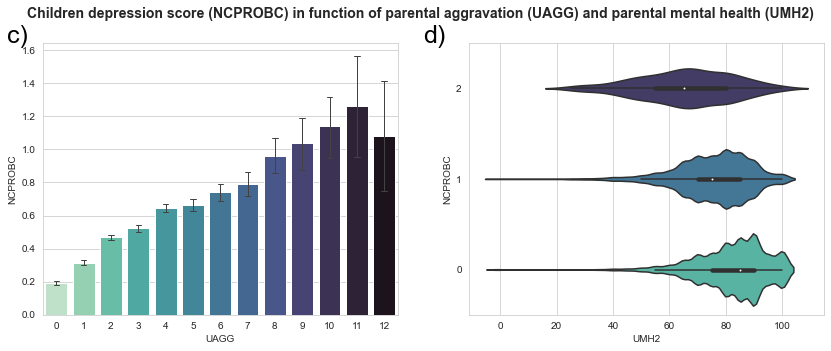

In [15]:
df=df_NN(fc23,outcome,predictors)
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UAGE', y='NCPROBC', palette='mako_r', data=df,capsize=0.3,errwidth=1,markers='.')
sns.barplot(ax=axes[1], y='NCPROBC', x='UFAMSTR', palette='mako', data=df,capsize=0.1,errwidth=1.5)
plt.suptitle('Children depression score (NCPROBC) in function of age and family structure', fontsize=14, fontweight='bold')
plt.show()
    
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].text(-0.1,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.barplot(ax=axes[0], x='UAGG', y='NCPROBC', palette='mako_r', data=df,capsize=0.2,errwidth=1)
sns.violinplot(ax=axes[1], x='UMH2', y='NCPROBC', palette='mako', data=df, orient='h',order=[2,1,0])
plt.suptitle('Children depression score (NCPROBC) in function of parental aggravation (UAGG) and parental mental health (UMH2)', fontsize=14, fontweight='bold')
plt.show()

**a)** 
**b)** 
**c)**
**d)**

#### **Parents' mental health `UMH2`**

In [16]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh+['SEX','BDISBL','UAGG']
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     370.8
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           2.84e-43
Time:                        22:52:34   Log-Likelihood:            -1.3095e+05
No. Observations:               33466   AIC:                         2.619e+05
Df Residuals:                   33455   BIC:                         2.620e+05
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       77.4133      0.940     82.327   

We can notice a few variables that have a strong impact on parental mental health `UMH2`:
- `U_SOCPOV`: The wealthier, the better the mental health.
- `BDISBL`: The mental health of the parents is worse when the child has a disability.
- `UAGG`: As expected, the more aggravating a child is, the worse the parent's mental health.

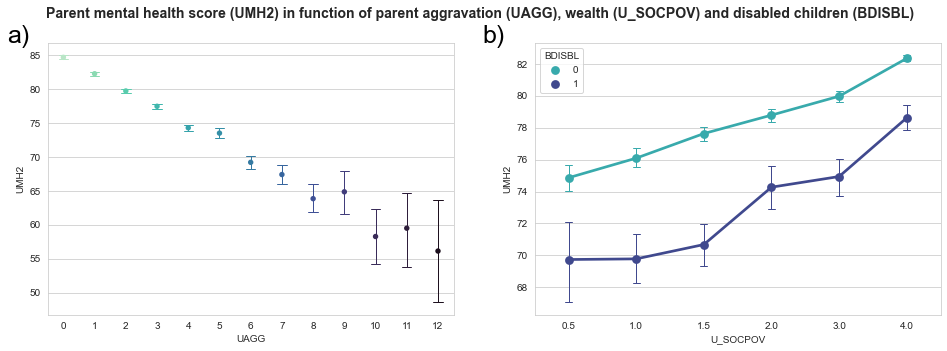

In [17]:
df = df_NN(child,outcome,predictors)
fig, axes = plt.subplots(1,2, figsize=(16,5))
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UAGG', y='UMH2', palette='mako_r', data=df,capsize=0.3,errwidth=1,markers='.')
sns.pointplot(ax=axes[1], x='U_SOCPOV', y='UMH2', hue='BDISBL', palette='mako_r', data=df, capsize=0.1, errwidth=1)
plt.suptitle('Parent mental health score (UMH2) in function of parent aggravation (UAGG), wealth (U_SOCPOV) and disabled children (BDISBL)', fontsize=14, fontweight='bold')
plt.show()

**a)** 
**b)** 

## Propensity score

__Living conditions indicator :__

In [18]:
# Variables used for precarity indicator (economics and relationship with family)
# NB CHOICE OF WORDS : PRECARITY NOT VERY ACCURATE
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']

df_prec = df_NN(fc23,'PERSID',prec)

In [19]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them -> WE CAN CHOOSE WEIGHTS LATER TO TUNE THE INDEX
# NB performs column-wise automatically
norm_prec =(df_prec[prec]-df_prec[prec].min())/(df_prec[prec].max()-df_prec[prec].min())
norm_prec.loc[:,negative] *= -1

weights = [2.5,7,0.5,0.5,0.25,2]

# Compute living conditions indicator
norm_prec.loc[:,'living_ind'] = norm_prec.dot(weights)

# Choose a threshold to consider a household 'precarious' or not (we chose the value 1)
norm_prec.loc[:,'precarious'] = norm_prec['living_ind'].apply(lambda x : 1 if x < 0 else 0)

norm_prec['living_ind'].describe()

count    21515.000000
mean         1.371713
std          1.704213
min         -7.708333
25%          0.214286
50%          1.691964
75%          2.847222
max          4.187500
Name: living_ind, dtype: float64

In [20]:
# Merge this new column with whole df without NaNs
fc23_prec = pd.merge(fc23, norm_prec['precarious'], left_index=True, right_index=True, how='inner')

**PS with `bool0_5` as a treatment**

In [21]:
# logistic regression for CHLD0_5
# NB changed to fc23 rather than child, removed BHLTHN from PS calculation
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT','OVERCROWDING','BDISBL','UHINS4','NCPROBC']
df_05 = df_NN(fc23,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + UHINS4 + NCPROBC'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()
res1.summary()

Optimization terminated successfully.
         Current function value: 0.497028
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                21388
Model:                          Logit   Df Residuals:                    21371
Method:                           MLE   Df Model:                           16
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                  0.1653
Time:                        22:52:36   Log-Likelihood:                -10630.
converged:                       True   LL-Null:                       -12735.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.0951      0.214    -19.155      0.000      -4.514      -3.676
UREGION[T.2]    -0.0138      0.049     -0.282      0.778      -0.110       0.082
UREGION[T.3]     0.0233      0.050      0.469      0.639      -0.074       0.121
UREGION[T.4]     0.0010      0.051      0.020      0.984      -0.099       0.101
SEX              0.0014      0.034      0.041      0.967      -0.066       0.068
UFAMSTR         -0.0123      0.020     -0.621      0.535      -0.051       0.027
UMH2             0.0066      0.001      4.648      0.000       0.004       0.009
UMHIGDEG        -0.0239      0.009     -2.617      0.009      -0.042      -0.006
UAGG             0.0291      0.010      2.928      0.003       0.010       0.049
UHHCOUNT         0.7226      0.029     24.551      0.000       0.665       0.780
U_SOCPOV        -0.2050      0.018    -11.651      0.000      -0.239      -0.170
MNBEDRMS        -0.1381      0.042     -3.315      0.001      -0.220      -0.056
MOWNRENT         0.2268      0.039      5.863      0.000       0.151       0.303
OVERCROWDING     0.3144      0.073      4.280      0.000       0.170       0.458
BDISBL          -0.2739      0.054     -5.031      0.000      -0.381      -0.167
UHINS4          -0.0901      0.020     -4.446      0.000      -0.130      -0.050
NCPROBC          0.0137      0.034      0.406      0.685      -0.052       0.080
================================================================================
"""

In [22]:
# from the logistic regression, compute the predicted propensity from the training set
pred05 = res1.predict(df_05.copy())
df_05.loc[:,'PS'] = pred05

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## PS matching

### Useful methods

In [23]:
# Finds closest PS to the input 'score' from the inputted array 'array'.
# Returns value of PS and its difference with 'score'.
def find_nearest(array, score):
    array = np.asarray(array)
    idx = (np.abs(array - score)).argmin()
    matchps = array[idx]
    return matchps, np.abs(matchps-score)

In [24]:
# Returns a dataframe containing two equally numbered populations (control, treatment) with ideally matched propensity scores
def optimatch(ctrl_df,trtm_df,alpha=0.01):
    idx=[]
    idtrtm=[]
    if (trtm_df.shape[0] > ctrl_df.shape[0]): # we iterate over the smaller dataframe and use the other one as a pool
        trtm_df, ctrl_df = ctrl_df, trtm_df
    iterative_df = trtm_df.reset_index(drop=True).copy().sample(frac=1) # shuffles the df so that we don't always preferentially optimize the first rows
    pool_df = ctrl_df.reset_index(drop=True).copy()
    for i in range(0,iterative_df.shape[0]):
        ps = iterative_df.iloc[i].PS
        matched, diff = find_nearest(pool_df.PS.drop(idx),ps)
        if (diff < alpha):
            idx.append(pool_df[pool_df.PS == matched].index[0]) 
            idtrtm.append(i)
    return pool_df.iloc[idx].append(iterative_df.iloc[idtrtm])

#### Matching with `bool0_5`

In [25]:
# plots the matched vs unmatched repartition of 1) PS and 2) a random variable var
def plotPS(unmatched,treatment,var,ret=False):
    
    treated = unmatched[unmatched[treatment]==1].sample(frac=1).reset_index(drop=True)
    control = unmatched[unmatched[treatment]==0].sample(frac=1).reset_index(drop=True)
    
    matched = optimatch(treated,control,0.001)
    
    print(f'Number of treated subjects : {treated.shape[0]} \n\
Number of control subjects : {control.shape[0]} \n\
Number of matched pairs : {matched[matched[treatment]==1].shape[0]}')
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
    sns.histplot(ax = axes[0], data=unmatched, x="PS", hue=treatment, kde=True, element='step', stat='density', common_norm=False, palette= customDark)
    sns.histplot(ax = axes[1], data=matched, x="PS", hue=treatment, kde=True, element='step', stat='density', common_norm=False, palette = customDark)
    plt.suptitle('Propensity score distribution for unmatched and matched samples', fontsize=14, fontweight='bold')
    plt.show()
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
    sns.kdeplot(ax=axes[0], data=unmatched, x=var, hue=treatment, palette=['r','g'], shade=True, common_norm=False)
    sns.kdeplot(ax=axes[1], data=matched, x=var, hue=treatment, palette=['r','g'], shade=True)
    axes[0].set_xlim(0,5)
    axes[1].set_xlim(0,5)
    plt.suptitle(var+' distribution for unmatched and matched samples', fontsize=14, fontweight='bold')
    plt.show()
    
    if(ret):
        return matched

Number of treated subjects : 6045 
Number of control subjects : 15343 
Number of matched pairs : 5154


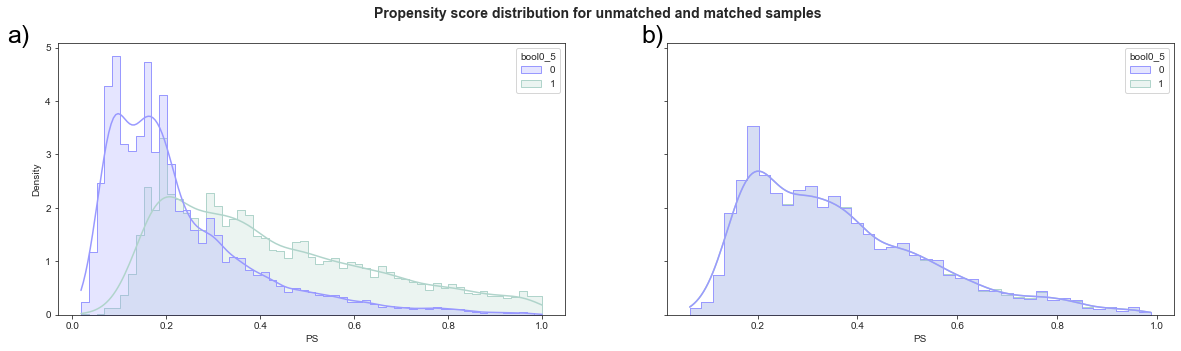

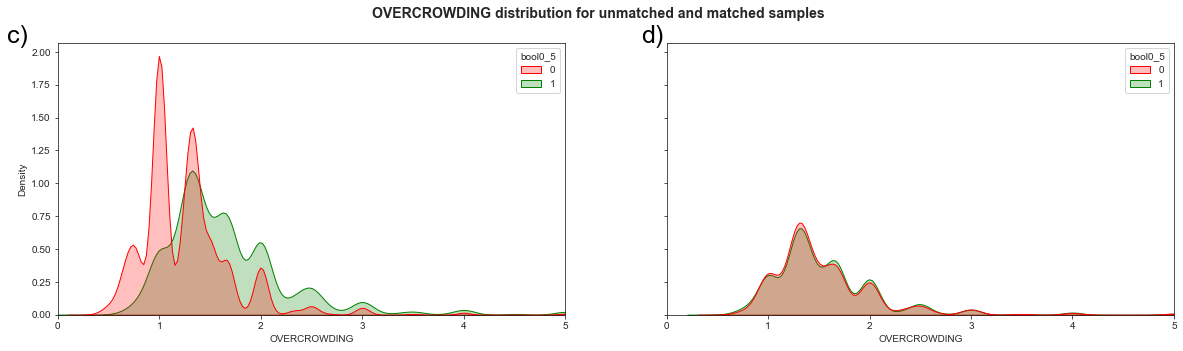

In [26]:
sns.set_style('ticks')
plotPS(df_05,'bool0_5','OVERCROWDING')

# similar curves with matching !

**PS with `NLESSONS` as treatment**

In [27]:
# logistic regression for NLESSONS
# NB removed BHLTHN
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS',
             'MOWNRENT','OVERCROWDING','BDISBL','CSPECED','UHINS4','NCPROBC']
df_lessons = df_NN(fc23,'NLESSONS',predictors)

log_model_L = 'NLESSONS ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + CSPECED + UHINS4 + NCPROBC'

log_L = smf.logit(formula=log_model_L, data=df_lessons)
res_L = log_L.fit()
res_L.summary()

Optimization terminated successfully.
         Current function value: 0.600002
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               NLESSONS   No. Observations:                21211
Model:                          Logit   Df Residuals:                    21193
Method:                           MLE   Df Model:                           17
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                 0.06102
Time:                        22:52:48   Log-Likelihood:                -12727.
converged:                       True   LL-Null:                       -13554.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5093      0.190    -13.186      0.000      -2.882      -2.136
UREGION[T.2]    -0.2669      0.043     -6.235      0.000      -0.351      -0.183
UREGION[T.3]    -0.3963      0.044     -8.919      0.000      -0.483      -0.309
UREGION[T.4]    -0.2153      0.045     -4.802      0.000      -0.303      -0.127
SEX              0.7442      0.031     24.299      0.000       0.684       0.804
UFAMSTR          0.1303      0.018      7.222      0.000       0.095       0.166
UMH2             0.0053      0.001      4.054      0.000       0.003       0.008
UMHIGDEG         0.1004      0.008     12.088      0.000       0.084       0.117
UAGG            -0.0108      0.009     -1.175      0.240      -0.029       0.007
UHHCOUNT        -0.0729      0.026     -2.819      0.005      -0.124      -0.022
U_SOCPOV         0.1779      0.016     10.798      0.000       0.146       0.210
MNBEDRMS         0.1239      0.035      3.511      0.000       0.055       0.193
MOWNRENT         0.0620      0.036      1.698      0.089      -0.010       0.134
OVERCROWDING    -0.0548      0.071     -0.776      0.438      -0.193       0.084
BDISBL          -0.2012      0.059     -3.401      0.001      -0.317      -0.085
CSPECED         -0.1836      0.058     -3.173      0.002      -0.297      -0.070
UHINS4          -0.0709      0.019     -3.813      0.000      -0.107      -0.034
NCPROBC         -0.0232      0.030     -0.767      0.443      -0.083       0.036
================================================================================
"""

In [28]:
pred_L = res_L.predict(df_lessons)
df_lessons.loc[:,'PS'] = pred_L

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Number of treated subjects : 7147 
Number of control subjects : 14064 
Number of matched pairs : 6754


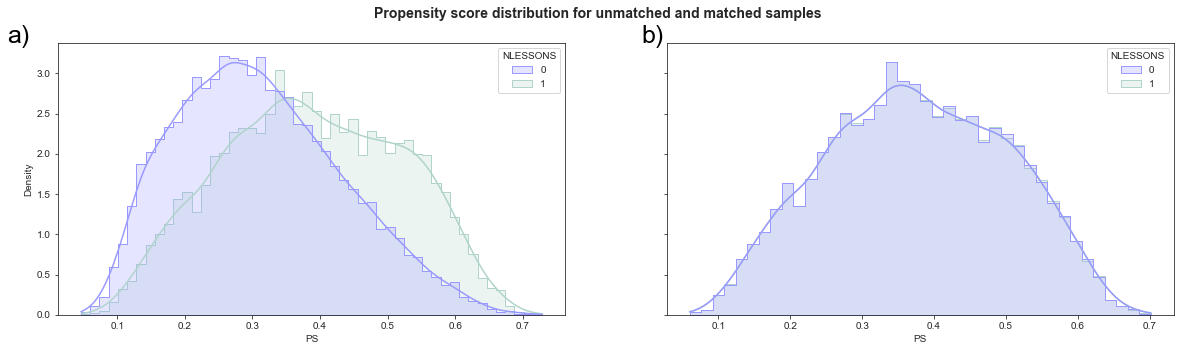

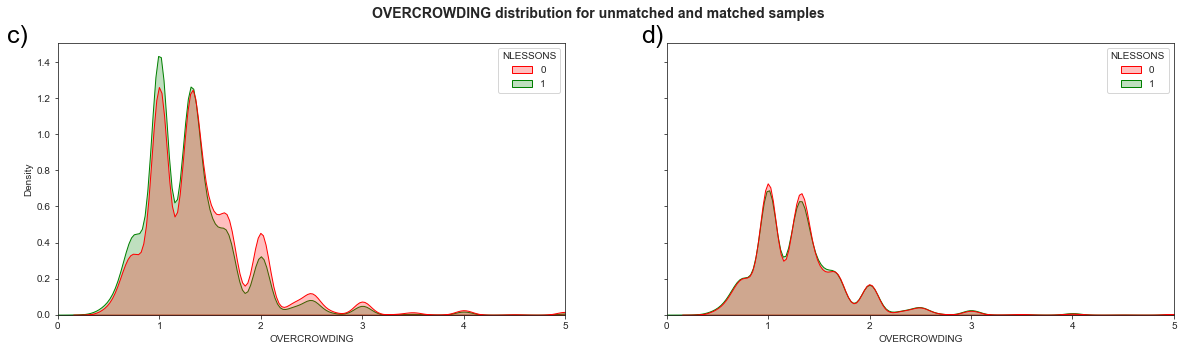

In [29]:
plotPS(df_lessons,'NLESSONS','OVERCROWDING')

**PS with `precarious` as treatment**

In [30]:
# logistic regression for precarious

predictors= ['SEX','UAGE','UREGION','UMHIGDEG','UHHCOUNT','MNBEDRMS',
             'OVERCROWDING','BDISBL','CSPECED','UACT']
df_prec_raw = df_NN(fc23_prec,'precarious',predictors)

log_model_prec = 'precarious ~ SEX + UAGE + UREGION + UMHIGDEG\
+ UHHCOUNT + MNBEDRMS + OVERCROWDING + BDISBL + CSPECED + UACT'

log_prec = smf.logit(formula=log_model_prec, data=df_prec_raw)
res_prec = log_prec.fit()
res_prec.summary()

Optimization terminated successfully.
         Current function value: 0.385589
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                21317
Model:                          Logit   Df Residuals:                    21304
Method:                           MLE   Df Model:                           12
Date:                Tue, 15 Dec 2020   Pseudo R-squ.:                  0.2657
Time:                        22:53:02   Log-Likelihood:                -8219.6
converged:                       True   LL-Null:                       -11194.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.3223      0.270     -4.900      0.000      -1.851      -0.793
UREGION[T.2]    -0.2333      0.060     -3.910      0.000      -0.350      -0.116
UREGION[T.3]     0.4243      0.056      7.607      0.000       0.315       0.534
UREGION[T.4]     0.0734      0.060      1.226      0.220      -0.044       0.191
SEX              0.1324      0.040      3.330      0.001       0.054       0.210
UAGE             0.0121      0.006      2.139      0.032       0.001       0.023
UMHIGDEG         0.0168      0.010      1.643      0.100      -0.003       0.037
UHHCOUNT         0.1807      0.053      3.419      0.001       0.077       0.284
MNBEDRMS        -0.8585      0.085    -10.143      0.000      -1.024      -0.693
OVERCROWDING     1.3963      0.150      9.331      0.000       1.103       1.690
BDISBL           0.3663      0.066      5.591      0.000       0.238       0.495
CSPECED          0.2227      0.066      3.383      0.001       0.094       0.352
UACT            -0.4732      0.022    -21.590      0.000      -0.516      -0.430
================================================================================
"""

In [31]:
pred_prec = res_prec.predict(df_prec_raw)
df_prec_raw.loc[:,'PS'] = pred_prec

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Number of treated subjects : 4660 
Number of control subjects : 16657 
Number of matched pairs : 3463


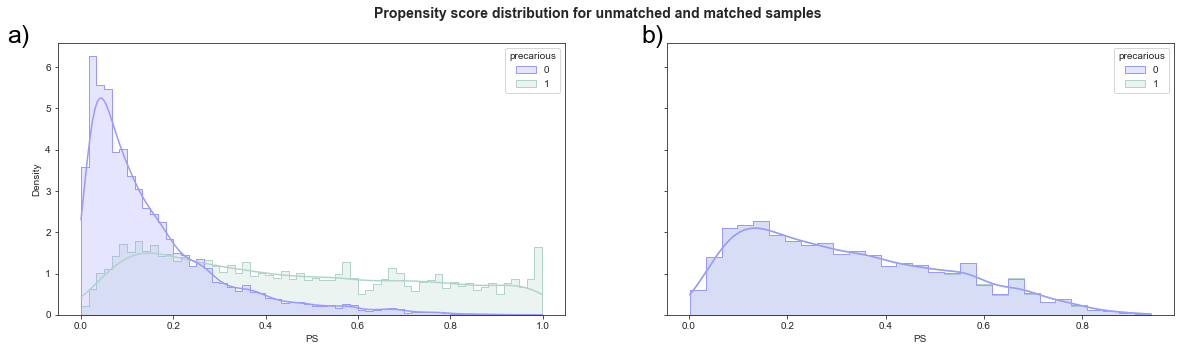

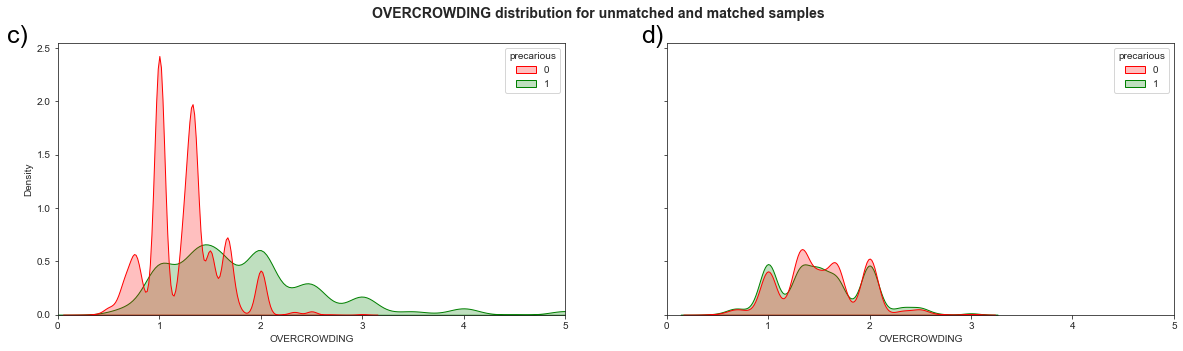

In [32]:
df_prec = plotPS(df_prec_raw,'precarious','OVERCROWDING',True)

In [33]:
means_prec = df_prec_raw.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGn'][0] - means_prec['UENGn'][1]))
means_prec

Diff of mean = 0.0706770388198511


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,NLESSONS,CSPECED,UFAMSTR,UMHIGDEG,...,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,UAGGn,NCPROBCn,bool0_5,PS
precarious,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.490725,11.642913,12.751156,0.194333,0.337035,0.365612,0.112865,3.424326,3.664766,...,0.723485,0.154365,-0.115732,-0.057909,0.738142,0.525365,0.170129,0.207600,0.236777,0.153929
1,2.0,0.493348,11.155150,11.931330,0.292060,0.229828,0.227039,0.174893,2.377253,3.767167,...,0.652808,0.270440,-0.034996,-0.188805,0.661142,0.342489,0.212160,0.237017,0.442918,0.449786


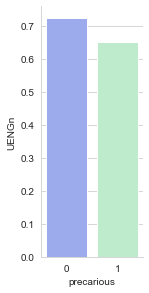

In [34]:
with sns.axes_style("whitegrid"):
    sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGn',kind='bar', palette=customLight, height=4, aspect=0.5)

In [35]:
means_prec = df_prec.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGn'][0] - means_prec['UENGn'][1]))

Diff of mean = 0.03450765232457331


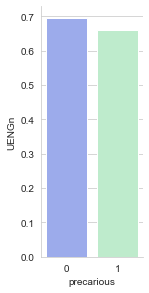

In [36]:
with sns.axes_style("whitegrid"):
    sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGn',kind='bar',palette=customLight, height=4, aspect=0.5)

## Average treatment effect on schooling, health & happiness

Using the matched pairs we can compute average treatment effects of precarity on our variables of interest.

__ATE of having a young child (or children) in the household__

In [37]:
# Computes CI
def CI(alpha, data):    
    ci = sms.DescrStatsW(data).tconfint_mean(alpha)
    return ci

In [38]:
# computes and returns the significance (***=1%, **=5%, *=10%)
def stars(ci):
    if np.sign(ci[2][0]) == np.sign(ci[2][1]):
        return '***'
    elif np.sign(ci[1][0]) == np.sign(ci[1][1]):
        return '**'
    elif np.sign(ci[0][0]) == np.sign(ci[0][1]):
        return '*'
    else:
        return 'Not significant'

In [39]:
# Computes average treatment effect of 'treatment_var' on the variable of interest 'voi'
def ATE (data, treatment_var, voi):
    # keep only valid data for voi (no NaNs)
    df = df_NN(data,treatment_var,[voi])
    # perform matching
    treated = df[df[treatment_var] == 1].reset_index(drop=True)
    control = df[df[treatment_var] == 0].reset_index(drop=True)
    df_match = optimatch(treated,control,0.001)
    print(f'Number of matched subjects: {df_match.shape[0]} / {df.shape[0]}')

    pairs_difference = df_match.loc[df_match[treatment_var]==1,voi].values - df_match.loc[df_match[treatment_var]==0,voi].values
    
    ate = sum(pairs_difference)/pairs_difference.size
    ci = [ CI(0.1, pairs_difference), CI(0.05, pairs_difference), CI(0.01, pairs_difference)]
    star = stars(ci)
    
    return ate, ci, star

In [40]:
# Computes ATE of 'treatment_var' on several variables of interest listed in 'list_voi'
# Returns a dataframe with the variables and their ATE
def multiple_ATE (data, treatment_var, list_voi):
    ates = []
    stars = []
    ci90 = []
    ci95 = []
    ci99 = []
    
    for var in list_voi:
        print(var)
        ate, ci, star = ATE(data, treatment_var, var)
        ates.append(ate)
        stars.append(star)
        ci90.append(ci[0])
        ci95.append(ci[1])
        ci99.append(ci[2])
        
    df_ate = pd.DataFrame({'variable': list_voi, 'ATE': ates, 'ci90': ci90, 'ci95': ci95, 'ci99': ci99,
                           'Significance': stars})
    
    # nice display of confidence intervals
    for i in range(3):
        col = ['ci90','ci95','ci99']
        col_fmd = ['90% CI','95% CI','99% CI']
        df_ate.loc[:,col_fmd[i]] = df_ate[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')
    
    # ATE significance at the 95% level (positive or negative)
    df_ate.loc[:,'sig95'] = df_ate['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + df_ate['ATE'].apply(lambda x : 1 if x > 0 else 0)
    df_ate['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
    
    return df_ate

In [41]:
# Returns dataframe with variables of interest in this study with their confidence intervals and significance
def ATE_sch_hlth_happ (data, treatment_var, interest_var, fc2=False,fc3=False):
    ate = multiple_ATE(data, treatment_var, interest_var)
    if (fc2==True):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        return ate.append(ate_ubpia, ignore_index=True)
    if (fc3==True):
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpib, ignore_index=True)
    if ((fc2==False)and(fc3==False)):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpia.append(ate_ubpib,ignore_index=True), ignore_index=True)

In [42]:
# Plots ATEs of 'df' with 'treatment' (must be in ['child05','lessons','precarious'])
def plot_ATE (df, treatment):
    treatment_list = {'lessons' : 'taking lessons outside of school',
                      'precarious' : 'precarious living conditions'}
    tr = treatment_list[treatment]
    
    plt.figure(figsize=(10,5))
    groups = df.sort_values('ATE').groupby('sig95', sort=False)
    for sig, group in groups:
        error = group['ci95'].apply(pd.Series).to_numpy()
        length_error = abs(error[:,0] - group.ATE.values)
        plt.errorbar(group.ATE, group.variable, marker='o', ls='', xerr=length_error, capsize=3, elinewidth=0.75,label=sig)
    plt.axvline(0,color='k',linestyle='--')
    plt.xlabel('nATE (with 95% CI)', fontsize=12)
    plt.xlim(-0.1,0.1)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Normalized average treatment effect (nATE) of ' + tr + ' on several variables',
              fontweight='bold', fontsize=14)
    plt.legend()
    plt.show()

__ATE of `precarious` household__

In [43]:
ate_precarious = ATE_sch_hlth_happ(df_prec, 'precarious',['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'])
ate_precarious[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 6754 / 6854
BHLTHNn
Number of matched subjects: 6858 / 6926
UMH2n
Number of matched subjects: 6824 / 6916
UACTn
Number of matched subjects: 6842 / 6926
UAGGn
Number of matched subjects: 6856 / 6926
NCPROBCn
Number of matched subjects: 6818 / 6904
UBPIAn
Number of matched subjects: 3170 / 3631
UBPIBn
Number of matched subjects: 2852 / 3263


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.031339,[-0.040617 ; -0.022062],[-0.042396 ; -0.020283],[-0.045873 ; -0.016806],***
1,BHLTHNn,0.072324,[0.062904 ; 0.081744],[0.061099 ; 0.083550],[0.057569 ; 0.087080],***
2,UMH2n,-0.057460,[-0.065347 ; -0.049573],[-0.066859 ; -0.048061],[-0.069814 ; -0.045105],***
3,UACTn,0.002144,[-0.007654 ; 0.011941],[-0.009532 ; 0.013819],[-0.013204 ; 0.017491],Not significant
4,UAGGn,0.029001,[0.022109 ; 0.035894],[0.020788 ; 0.037215],[0.018205 ; 0.039798],***
5,NCPROBCn,0.030507,[0.018869 ; 0.042146],[0.016638 ; 0.044377],[0.012277 ; 0.048738],***
6,UBPIAn,-0.037382,[-0.048373 ; -0.026391],[-0.050481 ; -0.024283],[-0.054605 ; -0.020159],***
7,UBPIBn,-0.015136,[-0.027364 ; -0.002907],[-0.029710 ; -0.000561],[-0.034299 ; 0.004027],**


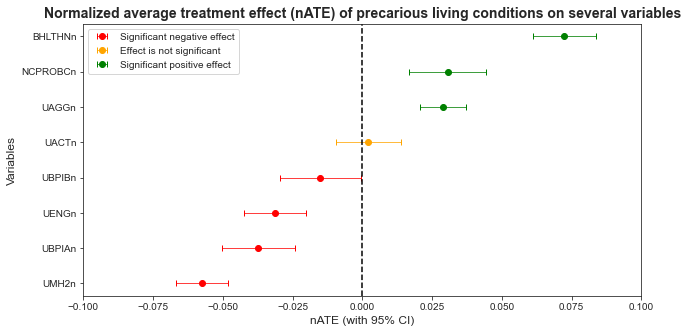

In [44]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'orange', 'green'])

plot_ATE(ate_precarious,'precarious')

As expected, a variable included in the propensity score (`UACTn`) doesn't show any significant ATE, as this variable is supposedly matched equally between the two populations.

__3) ATE of `precarious` household for two different age groups (6-11 vs. 12-17)__ 

Let's segregate the previous population into two and compute the multiple ATEs for each subpopulation (children vs. adolescents)

In [45]:
ate_precarious_fc2 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] < 12],'precarious',['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'],fc2=True)
ate_precarious_fc2[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 3180 / 3625
BHLTHNn
Number of matched subjects: 3176 / 3646
UMH2n
Number of matched subjects: 3174 / 3641
UACTn
Number of matched subjects: 3176 / 3646
UAGGn
Number of matched subjects: 3190 / 3646
NCPROBCn
Number of matched subjects: 3180 / 3637
UBPIAn
Number of matched subjects: 3160 / 3631


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.032862,[-0.045388 ; -0.020335],[-0.047791 ; -0.017933],[-0.052490 ; -0.013233],***
1,BHLTHNn,0.059824,[0.046595 ; 0.073052],[0.044058 ; 0.075589],[0.039095 ; 0.080553],***
2,UMH2n,-0.056476,[-0.067739 ; -0.045212],[-0.069899 ; -0.043052],[-0.074124 ; -0.038827],***
3,UACTn,0.006927,[-0.007381 ; 0.021235],[-0.010126 ; 0.023980],[-0.015494 ; 0.029348],Not significant
4,UAGGn,0.030146,[0.020269 ; 0.040024],[0.018375 ; 0.041918],[0.014669 ; 0.045623],***
5,NCPROBCn,0.044654,[0.028586 ; 0.060723],[0.025504 ; 0.063804],[0.019475 ; 0.069833],***
6,UBPIAn,-0.037078,[-0.048022 ; -0.026134],[-0.050121 ; -0.024035],[-0.054228 ; -0.019929],***


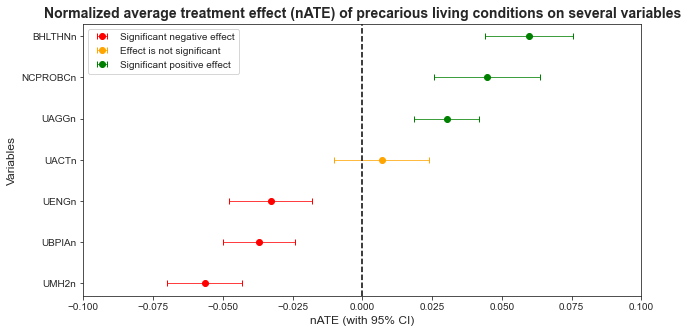

In [46]:
plot_ATE(ate_precarious_fc2,'precarious')

In [47]:
ate_precarious_fc3 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] >= 12],'precarious', ['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'], fc3=True)
ate_precarious_fc3[['variable','ATE','90% CI','95% CI','99% CI','Significance']].head()

UENGn
Number of matched subjects: 2826 / 3229
BHLTHNn
Number of matched subjects: 2864 / 3280
UMH2n
Number of matched subjects: 2854 / 3275
UACTn
Number of matched subjects: 2868 / 3280
UAGGn
Number of matched subjects: 2882 / 3280
NCPROBCn
Number of matched subjects: 2852 / 3267
UBPIBn
Number of matched subjects: 2860 / 3263


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.031316,[-0.046136 ; -0.016497],[-0.048979 ; -0.013654],[-0.054540 ; -0.008093],***
1,BHLTHNn,0.079958,[0.065185 ; 0.094732],[0.062351 ; 0.097565],[0.056807 ; 0.103109],***
2,UMH2n,-0.049960,[-0.062266 ; -0.037654],[-0.064627 ; -0.035294],[-0.069245 ; -0.030676],***
3,UACTn,0.010228,[-0.005208 ; 0.025664],[-0.008169 ; 0.028625],[-0.013962 ; 0.034417],Not significant
4,UAGGn,0.031807,[0.021240 ; 0.042374],[0.019213 ; 0.044400],[0.015248 ; 0.048366],***


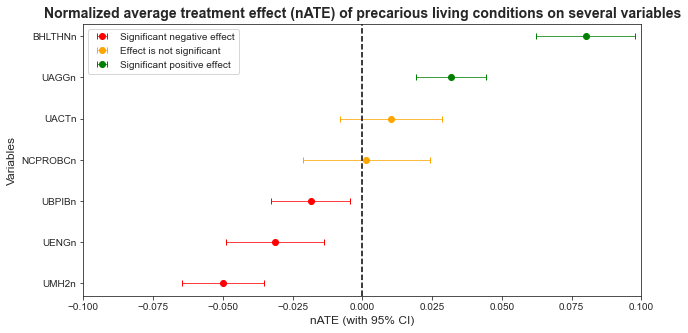

In [48]:
plot_ATE(ate_precarious_fc3,'precarious')

Let's now look for the difference in ATEs for the 2 subpopulations, in order to see which subgroup is more harshly impacted by precarity and for which oucome variables.

In [49]:
age_diff = pd.DataFrame(ate_precarious_fc3.variable)
ci90s = []
ci95s = []
ci99s = []
for i in range (0,ate_precarious_fc3.variable.size):
    ate = ate_precarious_fc3['ATE'][i] - ate_precarious_fc2['ATE'][i]
    age_diff.loc[i,'ATE'] = ate
    
    #ci qui est la diff des coordonnées des ci de fc2 et fc3 : 
    # ci=[(ate_precarious_fc3['ci90'][i][0] - ate_precarious_fc2['ci90'][i][0],ate_precarious_fc3['ci90'][i][1] - ate_precarious_fc2['ci90'][i][1]),(ate_precarious_fc3['ci95'][i][0] - ate_precarious_fc2['ci95'][i][0],ate_precarious_fc3['ci95'][i][1] - ate_precarious_fc2['ci95'][i][1]),(ate_precarious_fc3['ci99'][i][0] - ate_precarious_fc2['ci99'][i][0],ate_precarious_fc3['ci99'][i][1] - ate_precarious_fc2['ci99'][i][1])]
   
    #ci qui utilise la moitié de la taille de ci que les précédents: 
    ci = [(ate_precarious_fc3['ci90'][i][0]/2-ate_precarious_fc3['ATE'][i]/2+ate,ate_precarious_fc3['ci90'][i][1]/2-ate_precarious_fc3['ATE'][i]/2+ate),(ate_precarious_fc3['ci95'][i][0]/2-ate_precarious_fc3['ATE'][i]/2+ate,ate_precarious_fc3['ci95'][i][1]/2-ate_precarious_fc3['ATE'][i]/2+ate),(ate_precarious_fc3['ci99'][i][0]/2-ate_precarious_fc3['ATE'][i]/2+ate,ate_precarious_fc3['ci99'][i][1]/2-ate_precarious_fc3['ATE'][i]/2+ate)]
    
    ci90s.append(ci[0])
    ci95s.append(ci[1])
    ci99s.append(ci[2])
    age_diff.loc[i,'Significance'] = stars(ci)
    age_diff.loc[:,'sig95'] = age_diff['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + age_diff['ATE'].apply(lambda x : 1 if x > 0 else 0)
    age_diff['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
age_diff['ci90'] = ci90s
age_diff['ci95'] = ci95s
age_diff['ci99'] = ci99s

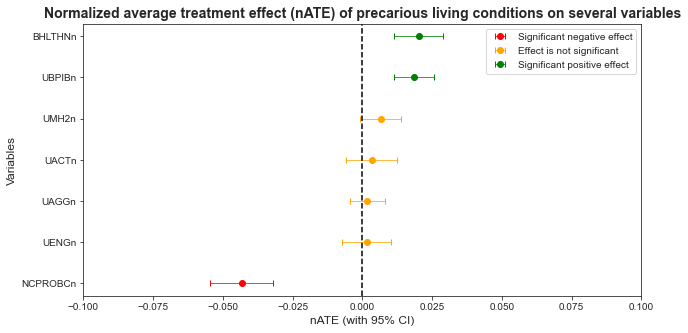

In [50]:
# Set the binary color cycle
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['orange','green']) 

plot_ATE(age_diff,'precarious')

#### fc3 - fc2 pour les valeurs, aucune des deux méthodes de CI me convient mais la première donne un meilleur truc (visuellement en tt cas) \\
     Plus le point est à adroite, + la variable en question est impactée par la précarité pour les 12-17. Plus c'est à gauche, plus la variable en question est impactée par la précarité pour les 6-11.

### Interesting effects of family structure and age on school involvement

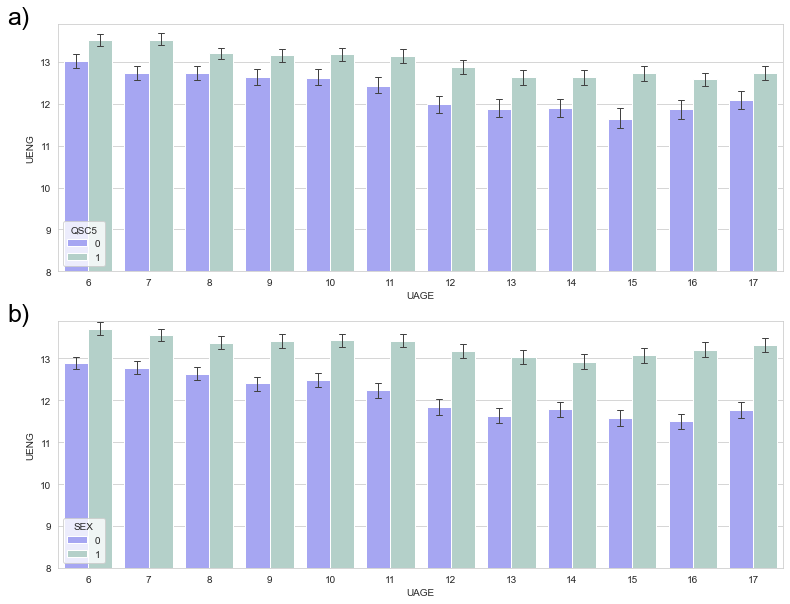

In [51]:
var='UENG'
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(2, figsize=(13,10))
    axes[0].text(-0.07,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[0].set_ylim(8,13.9)
    axes[1].text(-0.07,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
    axes[1].set_ylim(8,13.9)
    sns.barplot(ax=axes[0], x='UAGE', y=var, hue = 'QSC5', palette=customDark, data=df_NN(fc23,var,['UAGE','QSC5']), capsize=0.1, errwidth=1)
    sns.barplot(ax=axes[1], x='UAGE', y=var, hue = 'SEX', palette=customDark, data=df_NN(fc23,var,['UAGE','SEX']), capsize=0.1, errwidth=1)
plt.show()

**a)** Across all ages, having a family income under 2x the poverty line reduces scholar involvement.    
**b)** Overall, we can see a light reduction in school involvement with age. This reduction, however, is only significant with boys. N.B. we can also conclude that across all ages groups, girls are significantly more involved at school than boys. 

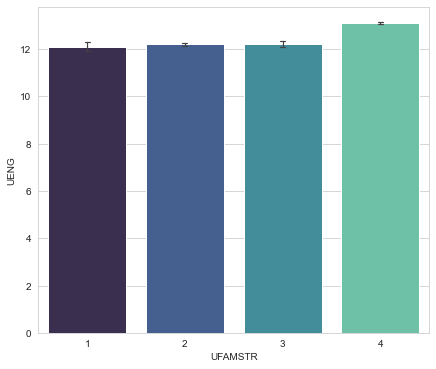

In [52]:
with sns.axes_style("whitegrid"):
    fig,ax = plt.subplots(figsize=(7,6))
    sns.barplot(y='UENG', x='UFAMSTR', palette='mako', data=df_NN(fc23,var,['UFAMSTR']), capsize=0.05, errwidth=1.2)
plt.show()

While not extremely significant as a whole (__see from part Lin reg UENG__), family structure still has an interesting effect on school involvement. Being under the supervision of two parents significantly improves scholar involvement. On the other hand, involvement is roughly the same for children brought up with no parents, 1 parent, or in a step-family. The latter fact is probably why `UFAMSTR` did not stand out as a very significant variable when linearly regressing it against `UENG`.